# Import Library 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import time
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
import math

In [2]:
def rand(random_seed = 777):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

# Parameter 

In [3]:
device = torch.device("cuda:4" if (torch.cuda.is_available()) else "cpu")

dataset_dir = './Dataset/'
transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
class_num = 2
num_workers = 0

input_channel = 3
channel = 64
batch_size = 4
num_epochs = 3
lr_D = 0.0004
lr_G = 0.0001
alpha = 10
beta = 1

save_dir = './CheckPoint'

# Utils 

### DataLoader

In [4]:
class YouTubePose(Dataset):
    def __init__(self, dataset_dir, class_num, transform = None):
        self.dataset_dir = dataset_dir
        self.class_num = class_num
        self.transform = transform
          
    def __len__(self):
        length = []
        for i in range(self.class_num):
            dir_path = self.dataset_dir +'train/class{}_cropped'.format(i + 1)
            length.append(len(os.walk(dir_path).__next__()[2]))
        max_len = max(length)
        return max_len    
    
    def __getitem__(self, idx):
        randx, randy = random.sample(range(1, self.class_num + 1), 2)
        #iden_equal을 x와 다른 클래스에서도 적용해보기.
        x, x_hat, identity_equal_1, identity_equal_2 = random.sample(os.listdir(self.dataset_dir + 
                                 'train/class{}_cropped'.format(randx)), 4)
        y = random.choice(os.listdir(self.dataset_dir + 
                                 'train/class{}_cropped'.format(randy)))
          
        x = Image.open(self.dataset_dir + 'train/class{}_cropped/'
                       .format(randx)+ x)
        y = Image.open(self.dataset_dir + 'train/class{}_cropped/'
                       .format(randy)+ y)
        x_hat = Image.open(self.dataset_dir + 'train/class{}_cropped/'
                           .format(randx)+ x_hat)
        
        identity_equal_1 = Image.open(self.dataset_dir + 'train/class{}_cropped/'
                                      .format(randx)+ identity_equal_1)
        identity_equal_2 = Image.open(self.dataset_dir + 'train/class{}_cropped/'
                                      .format(randx)+ identity_equal_2)
        
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)
            x_hat = self.transform(x_hat)
            identity_equal_1 = self.transform(identity_equal_1)
            identity_equal_2 = self.transform(identity_equal_2)
       
        sample = {'x' : x, 'y' : y, 'x_hat' : x_hat, 
                 'identity_equal_1' : identity_equal_1, 
                 'identity_equal_2' : identity_equal_2}
        
        return sample

### Loss

In [5]:
def Iden_loss(target, Input):
    batch_size = float(target.size()[0])
    target = 1.0 - target
    target = torch.sqrt(target ** 2)
    Input = torch.sqrt(Input ** 2)
    target = torch.sum(target)
    Input = torch.sum(Input)
    Iden_loss = (target + Input) / batch_size
    
    return Iden_loss

def Shape_loss(Input, target):
    batch_size = float(Input.size()[0])
    Shape_loss = torch.abs(target - Input)
    Shape_loss = torch.sum(Shape_loss) / batch_size
    
    return Shape_loss

### Weights Initialization 

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    
    if classname.find('Conv') != -1:
        nn.utils.spectral_norm(m)

# Model

### Residualblock 

In [7]:
def conv3x3(in_channels, out_channels, stride = 1, padding = 1,
           padding_mode = 'zeros'):
    return nn.Conv2d(in_channels, out_channels, kernel_size = 3,
                    stride = stride, padding = padding, padding_mode = padding_mode)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, padding = 1):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = conv3x3(out_channels, out_channels, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        #conv3x3을 정의해서 쓰면 nn.Sequential로 정리 못하는가?
        
    def forward(self, x):
        residual = x
        if torch.cuda.is_available():
             x = torch.cuda.FloatTensor(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + residual
        #out = self.relu(out) 
        #Clova code 에선 relu 통과x
        return out

### Generator 

In [8]:
class Generator(nn.Module):
    def __init__(self, resblock, padding_mode = 'zeros'):
        super(Generator, self).__init__()
        
        self.x_conv1 = nn.Sequential(
            nn.Conv2d(input_channel, channel, 7, 1, 3, padding_mode = padding_mode),
            nn.BatchNorm2d(channel),
            nn.ReLU(),
        )
        self.y_conv1 = nn.Sequential(
            nn.Conv2d(input_channel, channel, 7, 1, 3, padding_mode = padding_mode),
            nn.BatchNorm2d(channel),
            nn.ReLU(),
        )
        
        self.x_conv2 = nn.Sequential(
            nn.Conv2d(channel, channel * 2, 3, 2, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 2),
            nn.ReLU(),
        )
        self.y_conv2 = nn.Sequential(
            nn.Conv2d(channel, channel * 2, 3, 2, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 2),
            nn.ReLU(),
        )
        
        self.x_conv3 = nn.Sequential(
            nn.Conv2d(channel * 2, channel * 4, 3, 2, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 4),
            nn.ReLU(),
        )
        self.y_conv3 = nn.Sequential(
            nn.Conv2d(channel * 2, channel * 4, 3, 2, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 4),
            nn.ReLU(),
        )
        
        self.x_resblock = resblock(channel * 4, channel * 4)
        self.y_resblock = resblock(channel * 4, channel * 4)
        
        self.resblock = resblock(channel * 4, channel * 4)
        
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(channel * 4, channel * 2, 4, 2, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 2),
            nn.ReLU(),
        )
        
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(channel * 2, channel, 4, 2, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel),
            nn.ReLU(),
        )
        
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(channel, input_channel, 7, 1, 3, padding_mode = padding_mode),
            nn.Tanh(),
        )

    def forward(self, x, y):
        x_out = self.x_conv1(x) #size는 그대로 channel만 두배
        x_out = self.x_conv2(x_out) #size 1/2배 channel 두배
        x_out1 = x_out
        x_out = self.x_conv3(x_out)
        x_out2 = x_out
        x_out = self.x_resblock(x_out)
        x_out = self.x_resblock(x_out)
        
        y_out = self.y_conv1(y)
        y_out = self.y_conv2(y_out)
        y_out1 = y_out
        y_out = self.y_conv3(y_out)
        y_out2 = y_out
        y_out = self.y_resblock(y_out)
        y_out = self.y_resblock(y_out)
        
        #out = torch.cat([x_out, y_out], dim = 1) #channel 차원에 concat
        out = x_out + y_out
        out = self.resblock(out)
        out = self.resblock(out)
        
        #Shortcut resblock도 넣어보기.
        out = self.deconv1(out)
        out = self.deconv2(out)
        out = self.deconv3(out)
        return out

### Discriminator

In [9]:
class Discriminator(nn.Module): #batch Norm 사용 안하면? 어떨까
    def __init__(self, padding_mode = 'zeros'):
        super(Discriminator, self).__init__()
                
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel * 2, channel, 4, 2, 1, padding_mode = padding_mode),
            nn.LeakyReLU(0.2),
        )
        #4, 2, 1 이면 input image size의 절반이 output image size
        self.conv2 = nn.Sequential(
            nn.Conv2d(channel, channel * 2, 4, 2, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(channel * 2, channel * 4, 4, 2, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 4),
            nn.LeakyReLU(0.2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(channel * 4, channel * 4, 3, 1, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(channel * 4, channel * 4, 3, 1, 1, padding_mode = padding_mode),
            nn.BatchNorm2d(channel * 4),
            nn.LeakyReLU(0.2),
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(channel * 4, 1, 3, 1, 1, padding_mode = padding_mode),
        )
        
        self.maxpool = nn.MaxPool2d(8)
    
    def forward(self, x, y):
        xy = torch.cat([x,y], dim = 1)
        out = self.conv1(xy)
        out = self.conv2(out)
        out = self.conv3(out)
        out_neg = -out
        out_pooled = self.maxpool(out_neg)
        out_pooled = -out_pooled #Min-Patch
        
        return out, out_pooled

### Visualize datasets 

In [10]:
train_dataset = YouTubePose(dataset_dir, class_num, transform)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size,
                             shuffle = True, num_workers = num_workers)

generator = Generator(ResidualBlock).to(device)
generator.apply(weights_init)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

optimizer_G = optim.Adam(generator.parameters(), lr = lr_G, betas = (0.5,0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr = lr_D, betas = (0.5, 0.999))

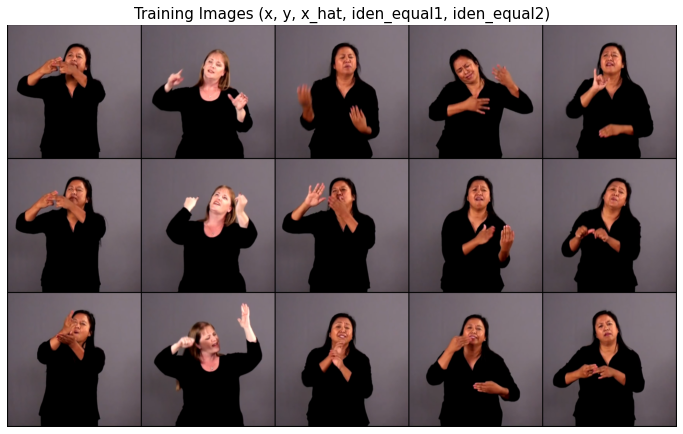

In [11]:
sample_list = []
for i in range(3):
    sample = next(iter(train_dataloader))
    sample_list.extend([sample['x'][0], sample['y'][0], sample['x_hat'][0], sample['identity_equal_1'][0], sample['identity_equal_2'][0]])

plt.figure(figsize=(12,20))
plt.axis('off')
plt.title('Training Images (x, y, x_hat, iden_equal1, iden_equal2)', size = 15)
plt.imshow(np.transpose(utils.make_grid(sample_list, padding = 2,
                                       normalize = True, nrow = 5),(1,2,0)))

# Training 

In [12]:
def save_checkpoint(state, dirpath, epoch):
    filename = 'checkpoint-{}.pt'.format(epoch)
    checkpoint_path = os.path.join(dirpath, filename)
    torch.save(state, checkpoint_path)
    print('--- checkpoint saved to ' + str(checkpoint_path) + ' ---')

In [13]:
generator = Generator(ResidualBlock).to(device)
generator.apply(weights_init)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

optimizer_G = optim.Adam(generator.parameters(), lr = lr_G, betas = (0.5,0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr = lr_D, betas = (0.5, 0.999))

real_label = 1.
fake_label = 0.

In [14]:
def Train():
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        print('-' * 10)

        dataloader = train_dataloader
        netG = generator
        netG.train()
        netD = discriminator
        netD.train()
        start = time.time()
        iden_loss = nn.MSELoss()
        shape_loss = nn.L1Loss()

        LI_G_list = []
        LI_D_list = []
        Ls_list = []

        for i, sample in enumerate(dataloader, 0): #start = 0
            x, y, x_hat = sample['x'], sample['y'], sample['x_hat']
            iden_equal1 = sample['identity_equal_1']
            iden_equal2 = sample['identity_equal_2']
            batch_size = x.size(0)
            with torch.autograd.detect_anomaly(): #nan 값이 나오기 전에 어디가 문제인지 알려줌.
                x = x.to(device)
                y = y.to(device)
                x_hat = x_hat.to(device)
                iden_equal1 = iden_equal1.to(device)
                iden_equal2 = iden_equal2.to(device)

                optimizer_G.zero_grad()
                optimizer_D.zero_grad()

                #Ix != Iy
                #Update G with maximize LI & Min-Patch Training
                output = netG(x, y)
                fake, fake_pooled = netD(x.detach(), output)
                real, real_pooled = netD(x.detach(), x_hat.detach())
                Real_label = torch.full((real_pooled.size()), real_label, dtype=torch.float, device=device)
                Fake_label = torch.full((fake_pooled.size()), fake_label, dtype=torch.float, device=device)
                iden_loss_G = iden_loss(Real_label, real_pooled) + iden_loss(Fake_label, fake_pooled)
                LI_G = -iden_loss_G #maximize LI
                LI_G_list.append(LI_G.item() / batch_size)
                LI_G.backward(retain_graph=True) #역전파 두번 사용시 필요
                optimizer_G.step()

                #Update D with minimize LI
                #Forward 여기서도 또 해보기 실험.
                optimizer_D.zero_grad()
                Real_label = torch.full((real.size()), real_label, dtype=torch.float, device=device)
                Fake_label = torch.full((fake.size()), fake_label, dtype=torch.float, device=device)
                iden_loss_D = iden_loss(Real_label, real) + iden_loss(Fake_label, fake)
                LI_D = iden_loss_D 
                LI_D_list.append(LI_D.item() / batch_size)
                LI_D.backward(retain_graph=True)
                optimizer_D.step()

                #Update G with minimize Ls2a, Ls2b
                optimizer_G.zero_grad()
                optimizer_D.zero_grad()
                output_ls2a = netG(y.detach(), output)
                output_ls2b = netG(output, y.detach())

                Ls2a = Shape_loss(y.detach(), output_ls2a)
                Ls2b = Shape_loss(output, output_ls2b)
                Ls2 = Ls2a + Ls2b
                Ls_list.append(Ls2.item() / batch_size)

                Ls2.backward()
                optimizer_G.step()

                #Ix == Iy
                #Update G with Ls1
                optimizer_G.zero_grad()
                optimizer_D.zero_grad()

                output_ls1 = netG(iden_equal1.detach(), iden_equal2.detach())

                Ls1 = Shape_loss(iden_equal2, output_ls1)
                Ls_list.append(Ls1.item() / batch_size)

                Ls1.backward()
                optimizer_G.step()

                if (i % 50 == 0):
                    print("[{:d}/{:d}] [{:d}/{:d}] LI_G:{:.4f}     LI_D:{:.4f}     Ls1:{:.4f}      Ls2a:{:.4f}      Ls2b:{:.4f}".
                 format(epoch, num_epochs, i, len(dataloader), LI_G, LI_D, Ls1, Ls2a, Ls2b))
                
        save_checkpoint({
                    'epoch': epoch + 1,
                    'netG_state_dict': netG.state_dict(),
                    'netD_state_dict': netD.state_dict(),
                    'gen_opt': optimizer_G.state_dict(),
                    'disc_opt': optimizer_D.state_dict()
                }, './CheckPoint/', epoch + 1)    
        
        print("="*100)
        print("Epoch Loss => LI_G:{:.4f} LI_D:{:.4f} Ls:{:.4f}".format(sum(LI_G_list) / len(LI_G_list), sum(LI_D_list) / len(LI_D_list) , sum(Ls_list) / len(Ls_list)))
        print('Time taken by epoch: {:.0f}h {:.0f}m {:0f}s'.format(((time.time() - start) // 60) // 60, (time.time() - start) // 60, (time.time() - start) % 60))
        print()
    print("Training is finished")

In [15]:
Train()

Epoch 1/3
----------
[0/3] [0/172] LI_G:-2.2625     LI_D:1.4409     Ls1:1.1733      Ls2a:13.0421      Ls2b:6.1960
[0/3] [50/172] LI_G:-1.4082     LI_D:0.8213     Ls1:0.1522      Ls2a:1.3767      Ls2b:0.3661
[0/3] [100/172] LI_G:-1.2145     LI_D:0.7692     Ls1:0.1134      Ls2a:1.0924      Ls2b:0.2565
[0/3] [150/172] LI_G:-1.1781     LI_D:0.7765     Ls1:0.1005      Ls2a:0.8633      Ls2b:0.2227
--- checkpoint saved to ./CheckPoint/checkpoint-1.pt ---
Epoch Loss => LI_G:-0.3118 LI_D:0.2035 Ls:0.2621
Time taken by epoch: 0h 3m 4.774288s

Epoch 2/3
----------
[1/3] [0/172] LI_G:-1.2300     LI_D:0.7617     Ls1:0.0919      Ls2a:0.8831      Ls2b:0.1991
[1/3] [50/172] LI_G:-1.7170     LI_D:0.7466     Ls1:0.1061      Ls2a:0.7955      Ls2b:0.1498
[1/3] [100/172] LI_G:-1.9370     LI_D:0.6947     Ls1:0.0644      Ls2a:0.6625      Ls2b:0.1441
[1/3] [150/172] LI_G:-1.9495     LI_D:0.6361     Ls1:0.0633      Ls2a:0.7730      Ls2b:0.2237
--- checkpoint saved to ./CheckPoint/checkpoint-2.pt ---
Epoch Loss

# Test 

### Model Load 

In [16]:
data = next(iter(train_dataloader))
x = data['x'].to(device)
y = data['y'].to(device)
check_path = './CheckPoint/'

In [17]:
generator = Generator(ResidualBlock)
generator.apply(weights_init)

filename = 'checkpoint-5.pt'
checkpoint_path = os.path.join(check_path, filename)
checkpoint = torch.load(checkpoint_path)
generator.load_state_dict(checkpoint['netG_state_dict'])
generator.to(device)

result = generator(x.to(device), y.to(device))

In [18]:
x = x.detach().cpu()
y = y.detach().cpu()
result = result.detach().cpu()

sample = []

for i in range(batch_size):
    sample.extend([x[i], y[i], result[i]])

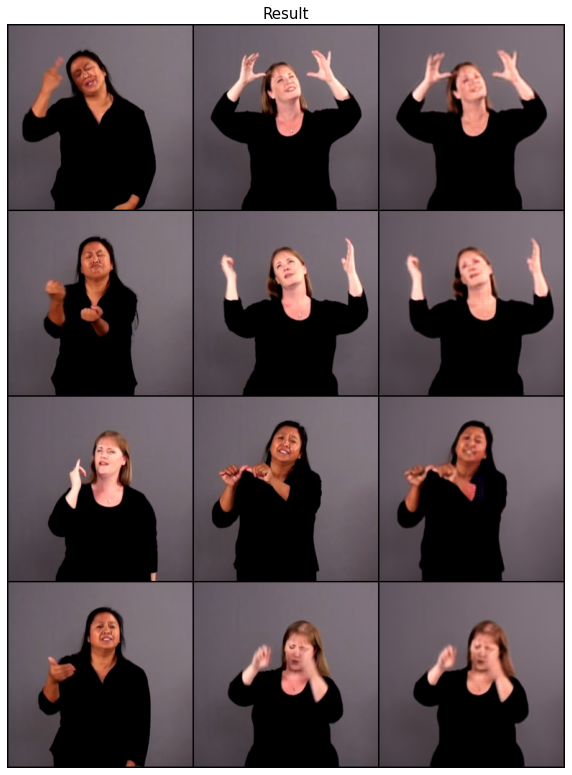

In [19]:
plt.figure(figsize=(10,30))
plt.axis('off')
plt.title('Result', size = 15)
plt.imshow(np.transpose(utils.make_grid(sample, padding = 2,
                                       normalize = True, nrow = 3),(1,2,0)))